In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.2-bin-hadoop3.2'

# Default Parameters

In [2]:
filename = "bank-full.csv"
target_variable_name = "y"

# Load Dataset

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

# Identify variable types

In [4]:
def variable_type(df):
    
    vars_list = df.dtypes
    char_vars = []
    num_vars = []
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])
    
    return char_vars, num_vars

In [5]:
char_vars, num_vars = variable_type(df)

In [6]:
char_vars

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [7]:
num_vars

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [8]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

def category_to_index(df, char_vars):
    
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

In [9]:
df, char_labels = category_to_index(df, char_vars)

In [10]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('job_index', 'double'),
 ('marital_index', 'double'),
 ('education_index', 'double'),
 ('default_index', 'double'),
 ('housing_index', 'double'),
 ('loan_index', 'double'),
 ('contact_index', 'double'),
 ('month_index', 'double'),
 ('poutcome_index', 'double'),
 ('y_index', 'double')]

In [11]:
df = df.select([c for c in df.columns if c not in char_vars])

In [12]:
from pyspark.sql.functions import col

def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

In [13]:
df = rename_columns(df, char_vars)

In [14]:
df.dtypes

[('age', 'int'),
 ('balance', 'int'),
 ('day', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('job', 'double'),
 ('marital', 'double'),
 ('education', 'double'),
 ('default', 'double'),
 ('housing', 'double'),
 ('loan', 'double'),
 ('contact', 'double'),
 ('month', 'double'),
 ('poutcome', 'double'),
 ('y', 'double')]

In [15]:
df.groupBy('y').count().show() 

+---+-----+
|  y|count|
+---+-----+
|0.0|39922|
|1.0| 5289|
+---+-----+



# Assemble input vectors

In [16]:
from pyspark.ml.feature import VectorAssembler

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [17]:
#exclude target variable and select all other feature vectors
features_list = df.columns
features_list.remove(target_variable_name)

In [18]:
features_list

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [19]:
# apply the function on our dataframe
df = assemble_vectors(df, features_list, target_variable_name)

In [20]:
df.show()

+---+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|  y|            features|age|balance|day|duration|campaign|pdays|previous| job|marital|education|default|housing|loan|contact|month|poutcome|
+---+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|0.0|(16,[0,1,2,3,4,5,...| 58|   2143|  5|     261|       1|   -1|       0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(16,[0,1,2,3,4,5,...| 44|     29|  5|     151|       1|   -1|       0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(16,[0,1,2,3,4,5,...| 33|      2|  5|      76|       1|   -1|       0| 7.0|    0.0|      0.0|    0.0|    0.0| 1.0|    1.0|  0.0|     0.0|
|0.0|(16,[0,1,2,3,4,5,...| 47|   1506|  5|      92|       1|   -1|       0| 0.0|    0.0|      3.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|

In [21]:
df.schema["features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'age'},
  {'idx': 1, 'name': 'balance'},
  {'idx': 2, 'name': 'day'},
  {'idx': 3, 'name': 'duration'},
  {'idx': 4, 'name': 'campaign'},
  {'idx': 5, 'name': 'pdays'},
  {'idx': 6, 'name': 'previous'}],
 'nominal': [{'vals': ['blue-collar',
    'management',
    'technician',
    'admin.',
    'services',
    'retired',
    'self-employed',
    'entrepreneur',
    'unemployed',
    'housemaid',
    'student',
    'unknown',
    '__unknown'],
   'idx': 7,
   'name': 'job'},
  {'vals': ['married', 'single', 'divorced', '__unknown'],
   'idx': 8,
   'name': 'marital'},
  {'vals': ['secondary', 'tertiary', 'primary', 'unknown', '__unknown'],
   'idx': 9,
   'name': 'education'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 10, 'name': 'default'},
  {'vals': ['yes', 'no', '__unknown'], 'idx': 11, 'name': 'housing'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 12, 'name': 'loan'},
  {'vals': ['cellular', 'unknown', 'telephone', '__unknown'],
   'idx': 13,


In [22]:
import pandas as pd
for k, v in df.schema["features"].metadata["ml_attr"]["attrs"].items():
    features_df = pd.DataFrame(v)

In [23]:
features_df

,vals,idx,name
0,"[blue-collar, management, technician, admin., ...",7,job
1,"[married, single, divorced, __unknown]",8,marital
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education
3,"[no, yes, __unknown]",10,default
4,"[yes, no, __unknown]",11,housing
5,"[no, yes, __unknown]",12,loan
6,"[cellular, unknown, telephone, __unknown]",13,contact
7,"[may, jul, aug, jun, nov, apr, feb, jan, oct, ...",14,month
8,"[unknown, failure, other, success, __unknown]",15,poutcome


# Model based feature selection

# Implement decision tree feature importance. Compare and contrast with Random Forest output.

In [24]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol=target_variable_name)
dt_model = dt.fit(df)
dt_model.featureImportances

SparseVector(16, {1: 0.0018, 2: 0.0024, 3: 0.5518, 8: 0.002, 9: 0.0009, 11: 0.0042, 13: 0.0051, 14: 0.1179, 15: 0.3138})

In [34]:
#temporary output rf_output
dt_output = dt_model.featureImportances
features_df['Decision_Tree'] = features_df['idx'].apply(lambda x: dt_output[x] if x in dt_output.indices  else 0)

In [31]:
#sort values based on descending importance feature
features_df.sort_values("Decision_Tree", ascending=False, inplace=True)

In [32]:
features_df

,vals,idx,name,Decision_Tree
8,"[unknown, failure, other, success, __unknown]",15,poutcome,0.313818
7,"[may, jul, aug, jun, nov, apr, feb, jan, oct, ...",14,month,0.117944
6,"[cellular, unknown, telephone, __unknown]",13,contact,0.005058
4,"[yes, no, __unknown]",11,housing,0.004203
1,"[married, single, divorced, __unknown]",8,marital,0.002022
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education,0.000896
0,"[blue-collar, management, technician, admin., ...",7,job,0.000000
3,"[no, yes, __unknown]",10,default,0.000000
5,"[no, yes, __unknown]",12,loan,0.000000


# Implement gradient boosted tree feature importance. Compare and contrast with Random Forest output.

In [35]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol='features', labelCol=target_variable_name)
gb_model = gb.fit(df)
gb_model.featureImportances

SparseVector(16, {0: 0.029, 1: 0.0107, 2: 0.0851, 3: 0.3006, 4: 0.0107, 5: 0.0421, 6: 0.0038, 7: 0.0291, 8: 0.0126, 9: 0.0042, 10: 0.0011, 11: 0.0505, 12: 0.0024, 13: 0.0546, 14: 0.3028, 15: 0.0609})

In [36]:
#temporary output rf_output
gb_output = gb_model.featureImportances
features_df['Gradient Boosting'] = features_df['idx'].apply(lambda x: gb_output[x] if x in gb_output.indices else 0)

In [37]:
#sort values based on descending importance feature
features_df.sort_values("Gradient Boosting", ascending=False, inplace=True)

In [38]:
features_df

,vals,idx,name,Decision_Tree,Gradient Boosting
7,"[may, jul, aug, jun, nov, apr, feb, jan, oct, ...",14,month,0.117944,0.302793
8,"[unknown, failure, other, success, __unknown]",15,poutcome,0.313818,0.060921
6,"[cellular, unknown, telephone, __unknown]",13,contact,0.005058,0.054572
4,"[yes, no, __unknown]",11,housing,0.004203,0.050522
0,"[blue-collar, management, technician, admin., ...",7,job,0.000000,0.029058
1,"[married, single, divorced, __unknown]",8,marital,0.002022,0.012554
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education,0.000896,0.004172
5,"[no, yes, __unknown]",12,loan,0.000000,0.002353
3,"[no, yes, __unknown]",10,default,0.000000,0.001085


# Random forest addition for voting based selection

In [46]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol=target_variable_name)
rf_model = rf.fit(df)
rf_model.featureImportances

SparseVector(16, {0: 0.0316, 1: 0.0045, 2: 0.0045, 3: 0.4569, 4: 0.0043, 5: 0.0183, 6: 0.0543, 7: 0.0073, 8: 0.004, 9: 0.0012, 10: 0.0, 11: 0.0441, 12: 0.0017, 13: 0.0345, 14: 0.169, 15: 0.1636})

In [47]:
#temporary output rf_output
rf_output = rf_model.featureImportances
features_df['Random Forest'] = features_df['idx'].apply(lambda x: rf_output[x] if x in rf_output.indices else 0)

In [48]:
#sort values based on descending importance feature
features_df.sort_values("Random Forest", ascending=False, inplace=True)

In [49]:
features_df

,vals,idx,name,Decision_Tree,Gradient Boosting,Random Forest
7,"[may, jul, aug, jun, nov, apr, feb, jan, oct, ...",14,month,0.117944,0.302793,0.168962
8,"[unknown, failure, other, success, __unknown]",15,poutcome,0.313818,0.060921,0.163645
4,"[yes, no, __unknown]",11,housing,0.004203,0.050522,0.044101
6,"[cellular, unknown, telephone, __unknown]",13,contact,0.005058,0.054572,0.034483
0,"[blue-collar, management, technician, admin., ...",7,job,0.000000,0.029058,0.007328
1,"[married, single, divorced, __unknown]",8,marital,0.002022,0.012554,0.003989
5,"[no, yes, __unknown]",12,loan,0.000000,0.002353,0.001698
2,"[secondary, tertiary, primary, unknown, __unkn...",9,education,0.000896,0.004172,0.001164
3,"[no, yes, __unknown]",10,default,0.000000,0.001085,0.000040


Text(0, 0.5, 'Variable Importance')

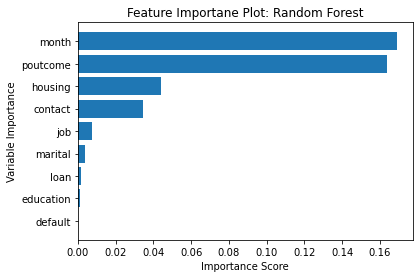

In [55]:
import matplotlib.pyplot as plt

features_df.sort_values("Random Forest", ascending=True, inplace=True)
plt.barh(features_df['name'], features_df['Random Forest'])
plt.title("Feature Importane Plot: Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Variable Importance")

Text(0, 0.5, 'Variable Importance')

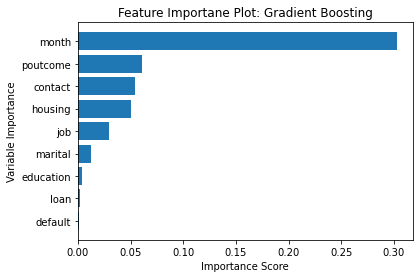

In [56]:
import matplotlib.pyplot as plt

features_df.sort_values("Gradient Boosting", ascending=True, inplace=True)
plt.barh(features_df['name'], features_df['Gradient Boosting'])
plt.title("Feature Importane Plot: Gradient Boosting")
plt.xlabel("Importance Score")
plt.ylabel("Variable Importance")

Text(0, 0.5, 'Variable Importance')

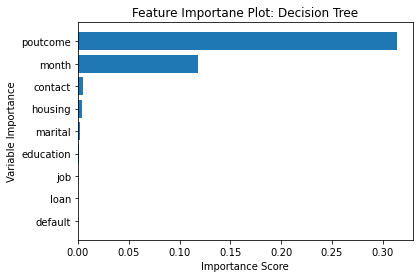

In [57]:
import matplotlib.pyplot as plt

features_df.sort_values("Decision_Tree", ascending=True, inplace=True)
plt.barh(features_df['name'], features_df['Decision_Tree'])
plt.title("Feature Importane Plot: Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Variable Importance")

# Voting based selection

In [50]:
features_df.drop('idx', axis=1, inplace=True)

In [51]:
num_top_features = 7
columns = ['Decision_Tree', 'Gradient Boosting', 'Random Forest']
score_table = pd.DataFrame({},[])
score_table['name'] = features_df['name']
for i in columns:
    score_table[i] = features_df['name'].isin(list(features_df.nlargest(num_top_features,i)['name'])).astype(int)

In [52]:
score_table['final_score'] = score_table.sum(axis=1)
score_table.sort_values('final_score',ascending=0)

,name,Decision_Tree,Gradient Boosting,Random Forest,final_score
7,month,1,1,1,3
8,poutcome,1,1,1,3
4,housing,1,1,1,3
6,contact,1,1,1,3
0,job,1,1,1,3
1,marital,1,1,1,3
2,education,1,1,0,2
5,loan,0,0,1,1
3,default,0,0,0,0


In [58]:
spark.stop()

### Great job!